In [7]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import time
from us import states
import gmaps
from scipy.stats import linregress
import random 


gmaps API Keys
from config import (census_key, gkey)

Configure gmaps
gmaps.configure(api_key=gkey)

In [8]:
#testing 
#!pwd

In [10]:
#load data
csv_path = "Resources/NutritionPhysicalActivityandObesity.csv"
nutrition_data = pd.read_csv(csv_path)
age_groups = nutrition_data.groupby('Age(years)')
year_groups = nutrition_data.groupby('YearEnd')

# Create a dataframe counting the number of data points for each age 
age_groups_count = pd.DataFrame(age_groups['Age(years)'].count())
year_groups_count = pd.DataFrame(year_groups['YearEnd'].count())

# View the groupby dataframe 
age_groups_count
nutrition_data.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Class,Topic,Question,Data_Value_Unit,Data_Value,Data_Value_Alt,...,Gender,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Stratification1
0,2012,2012,WY,Wyoming,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,48.5,48.5,...,NaN,NaN,American Indian/Alaska Native,"43.235541343, -108.109830353",OWS,OWS1,Q037,56,Race/Ethnicity,American Indian/Alaska Native
1,2012,2012,DC,District of Columbia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,31.6,31.6,...,NaN,NaN,NaN,"38.890371385, -77.031961127",OWS,OWS1,Q036,11,Education,Less than high school
2,2011,2011,AL,Alabama,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,35.2,35.2,...,NaN,NaN,NaN,"32.840571122, -86.631860762",OWS,OWS1,Q036,1,Age (years),25 - 34
3,2015,2015,RI,Rhode Island,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,40.2,40.2,...,NaN,NaN,Hispanic,"41.708280193, -71.522470314",OWS,OWS1,Q037,44,Race/Ethnicity,Hispanic
4,2012,2012,WY,Wyoming,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,NaN,32.3,32.3,...,NaN,"Less than $15,000",NaN,"43.235541343, -108.109830353",PA,PA1,Q047,56,Income,"Less than $15,000"


In [14]:
# drop unesscary columns and fix labels
nutrition_data = nutrition_data.drop(columns=['Data_Value_Unit',
                                              'StratificationCategory1',
                                              'YearStart',
                                              'ClassID',
                                              'TopicID',
                                              'Income',
                            
                                             ])
nutrition_data[['Lat','Long']] = nutrition_data.GeoLocation.str.split(",",expand=True,)

renamecols_df = nutrition_data.rename(columns={"LocationAbbr":"StateAbbr",
                                                "LocationDesc":"State",
                                                "Age(years)":"Age",
                                                "YearEnd":"Year"})

#renamecols is df before narrowing age demographic

In [15]:
#trim age column to include only desired age demographic

renamecols_df["Year"] = renamecols_df.Year.astype(str)

agedem_df = renamecols_df.loc[(renamecols_df["Age"] == "18 - 24")
                               |(renamecols_df["Age"] == "25 - 34")
                               |(renamecols_df["Age"] == "35 - 44")
                               |(renamecols_df["Age"] == "45 - 54")
                             ,:]
#dem_df trims years to include only five years of data 2014-2018
dem_df = agedem_df.loc[(agedem_df["Year"] == "2014")
                               |(agedem_df["Year"] == "2015")
                               |(agedem_df["Year"] == "2016")
                               |(agedem_df["Year"] == "2017")
                               |(agedem_df["Year"] == "2018")
                              ,:]
#define dataframe for obesity rates for gen x and gen y
GenX_Data = agedem_df[(agedem_df["Age"] == "35 - 44") | 
                        (agedem_df["Age"] == "45 - 54")]
GenM_Data = agedem_df[(agedem_df["Age"] == "18 - 24") | 
                        (agedem_df["Age"] == "25 - 34")]

In [16]:
#narrow dataframe for bargraph that compares obesity rate by age group from 2014-2018
obesity_data_df = dem_df.drop(columns=['Data_Value_Alt',
                                    'Total',
                                    'Education',
                                    'Gender',
                                    'Race/Ethnicity',
                                    'Topic',
                                    'Stratification1'
                                             ])

weight_q_group = obesity_data_df.loc[(dem_df["QuestionID"] == "Q036")                         
                              ,:]

#bin age data to gen x and gen y
# Create the bins in which gen x and gen y will be held   
bins = [['18 - 24','25 - 34'],['35 - 44','45-54']]

# Create the names for the five bins
group_names = ["Gen Y", "Gen X"]

b = (pd.DataFrame({'Gen': group_names, 'Age': bins})
        .explode('Age')
        .reset_index(drop=True))

obesity_data_df = weight_q_group.merge(b, on = 'Age', how='left')

s = pd.Series(obesity_data_df['Data_Value'])
pd.to_numeric(s)
#obesity_data_df.head()

0       29.7
1       33.2
2       37.9
3       12.7
4       19.9
        ... 
1015    25.4
1016    31.7
1017    28.0
1018    33.7
1019    39.3
Name: Data_Value, Length: 1020, dtype: float64

In [17]:
subjecttest = ['Data_Value']
datasettest = obesity_data_df.groupby(['Year','Age'])[subjecttest].mean()
datasettest

Data_Value
Year Age                
2014 18 - 24   16.307843
     25 - 34   27.978431
     35 - 44   33.125490
     45 - 54   34.017647
2015 18 - 24   17.233333
     25 - 34   27.272549
     35 - 44   32.919608
     45 - 54   34.439216
2016 18 - 24   17.498039
     25 - 34   27.674510
     35 - 44   33.786275
     45 - 54   35.415686
2017 18 - 24   17.525490
     25 - 34   29.284314
     35 - 44   33.819608
     45 - 54   36.500000
2018 18 - 24   18.496078
     25 - 34   30.147059
     35 - 44   35.090196
     45 - 54   37.770588

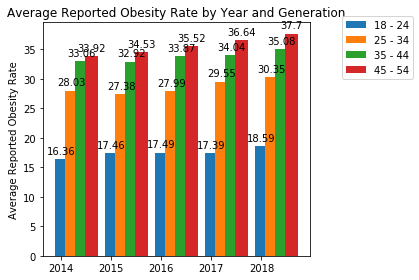

In [58]:
hhlabels =['Gen Y', 'Gen X']
labels = ['2014', '2015', '2016', '2017', '2018']
age1_means = [16.36, 17.46, 17.49, 17.39, 18.59]
age2_means = [28.03, 27.38, 27.99, 29.55, 30.35]
age3_means = [33.06, 32.92, 33.87, 34.04, 35.08]
age4_means = [33.92, 34.53, 35.52, 36.64, 37.70]

x = np.arange(len(labels))
hx = np.arange(len(hhlabels))  
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x + 0.00, age1_means, width, label='18 - 24')
rects2 = ax.bar(x + 0.20, age2_means, width, label='25 - 34')
rects3 = ax.bar(x + 0.40, age3_means, width, label='35 - 44')
rects4 = ax.bar(x + 0.60, age4_means, width, label='45 - 54')

ax.set_ylabel('Average Reported Obesity Rate')
ax.set_title('Average Reported Obesity Rate by Year and Generation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.1, 1.05))


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

In [49]:
#define data frame for bargraph comparing reported obesity rates by year and generation
subject = ['Data_Value']
dataset = obesity_data_df.groupby(['Year','Gen'])[subject].mean()
#dataset

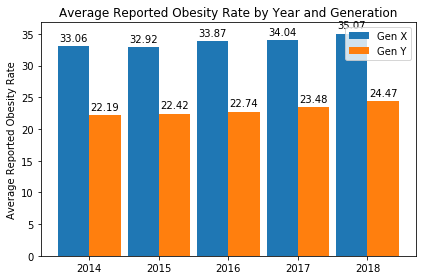

In [20]:
#Bar graph comparing Gen X and Gen Y obesity rate over time
labels = ['2014', '2015', '2016', '2017', '2018']
Genx_means = [33.06, 32.92, 33.87, 34.04, 35.07]
GenY_means = [22.19, 22.42, 22.74, 23.48, 24.47]
#formatting
x = np.arange(len(labels))  
width = 0.45

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Genx_means, width, label='Gen X')
rects2 = ax.bar(x + width/2, GenY_means, width, label='Gen Y')

# labels and markers
ax.set_ylabel('Average Reported Obesity Rate')
ax.set_title('Average Reported Obesity Rate by Year and Generation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#for loop for each rect in plt
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [21]:
GenM_Weight_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]
GenX_Weight_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]

In [22]:
GenX_activity_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
GenM_activity_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]

In [23]:
GenM_nutrition_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily")|(GenM_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily")]
GenX_nutrition_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily")|(GenX_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily")]

In [28]:
#GenX_Weight_df.dropna(subset=['Data_Value'])
GenX_sample_list = GenX_Weight_df["Data_Value"].tolist()
GenX_WeightSample = random.sample(GenX_sample_list, (204))

    
#GenM_Weight_df.dropna(subset=['Data_Value'])
GenM_sample_list = GenM_Weight_df["Data_Value"].tolist()
GenM_WeightSample = random.sample(GenM_sample_list, (204))

The correlation between both factors is 0.0


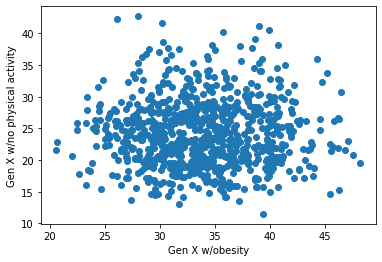

In [30]:
# The next example will compute the Pearson correlation coefficient between "GenX_Weight" and "GenX_Activity"
GenX_Weight = GenX_Weight_df.iloc[:,7]
GenX_Activity = GenX_activity_df.iloc[:,7]
correlation = sts.pearsonr(GenX_Weight,GenX_Activity)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenX_Weight,GenX_Activity)
plt.xlabel('Gen X w/obesity')
plt.ylabel('Gen X w/no physical activity')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is -0.07


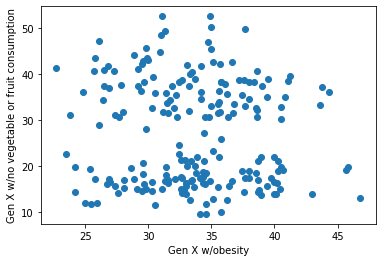

In [31]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenX_Weightsample = GenX_WeightSample
GenX_Nutrition = GenX_nutrition_df.iloc[:,7]
correlation = sts.pearsonr(GenX_Weightsample,GenX_Nutrition)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenX_WeightSample,GenX_Nutrition)
plt.xlabel('Gen X w/obesity')
plt.ylabel('Gen X w/no vegetable or fruit consumption')
print(f"The correlation between both factors is {round(correlation[0],2)}")

plt.show()

The correlation between both factors is 0.04


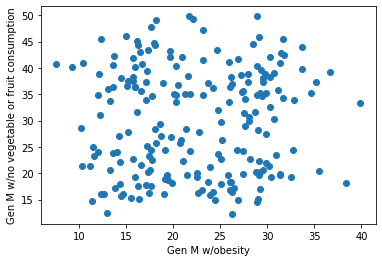

In [32]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenM_WeightSample = GenM_WeightSample
GenM_Nutrition = GenM_nutrition_df.iloc[:,7]
correlation = sts.pearsonr(GenM_WeightSample,GenM_Nutrition)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenM_WeightSample,GenM_Nutrition)
plt.xlabel('Gen M w/obesity')
plt.ylabel('Gen M w/no vegetable or fruit consumption')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is 0.04


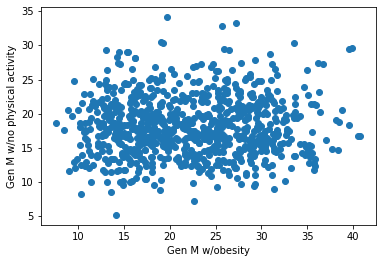

In [33]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenM_Weight = GenM_Weight_df.iloc[:,7]
GenM_Activity = GenM_activity_df.iloc[:,7]
correlation = sts.pearsonr(GenM_Weight,GenM_Activity)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenM_Weight,GenM_Activity)
plt.xlabel('Gen M w/obesity')
plt.ylabel('Gen M w/no physical activity')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The r-squared is: 0.0013907261339774725


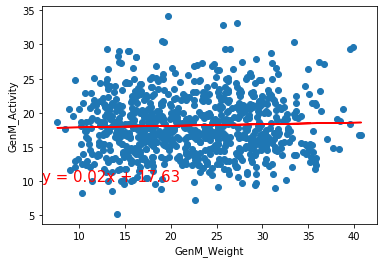

In [34]:

# Print out the r-squared value along with the plot.
x_values = GenM_Weight
y_values = GenM_Activity
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('GenM_Weight')
plt.ylabel('GenM_Activity')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [35]:
Top10 = GenX_Weight_df.sort_values('Data_Value', ascending = False).head(10)
Top10

,Year,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,High_Confidence_Limit,...,Age,Education,Gender,Race/Ethnicity,GeoLocation,QuestionID,LocationID,Stratification1,Lat,Long
12713,2018,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,48.2,48.2,44.0,52.3,...,45 - 54,NaN,NaN,NaN,"38.66551020200046, -80.71264013499967",Q036,54,45 - 54,38.66551020200046,-80.71264013499967
3308,2016,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,47.5,47.5,42.7,52.5,...,35 - 44,NaN,NaN,NaN,"32.745510099, -89.538030825",Q036,28,35 - 44,32.745510099,-89.538030825
26018,2017,AL,Alabama,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,47.1,47.1,43.2,51.1,...,45 - 54,NaN,NaN,NaN,"32.840571122, -86.631860762",Q036,1,45 - 54,32.840571122,-86.631860762
16626,2017,LA,Louisiana,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.8,46.8,42.2,51.4,...,45 - 54,NaN,NaN,NaN,"31.312660644, -92.445680071",Q036,22,45 - 54,31.312660644,-92.445680071
29607,2017,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.4,46.4,42.6,50.2,...,45 - 54,NaN,NaN,NaN,"38.665510202, -80.712640135",Q036,54,45 - 54,38.665510202,-80.712640135
2328,2016,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.3,46.3,43.0,49.6,...,45 - 54,NaN,NaN,NaN,"38.665510202, -80.712640135",Q036,54,45 - 54,38.665510202,-80.712640135
7544,2018,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.3,46.3,42.4,50.4,...,45 - 54,NaN,NaN,NaN,"32.745510099000455, -89.53803082499968",Q036,28,45 - 54,32.745510099000455,-89.53803082499968
15140,2013,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.2,46.2,42.4,50.0,...,45 - 54,NaN,NaN,NaN,"32.745510099, -89.538030825",Q036,28,45 - 54,32.745510099,-89.538030825
11386,2018,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.2,46.2,41.5,51.1,...,35 - 44,NaN,NaN,NaN,"38.66551020200046, -80.71264013499967",Q036,54,35 - 44,38.66551020200046,-80.71264013499967
9117,2018,LA,Louisiana,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,45.8,45.8,41.6,50.1,...,45 - 54,NaN,NaN,NaN,"31.31266064400046, -92.44568007099969",Q036,22,45 - 54,31.31266064400046,-92.44568007099969


In [36]:
# Store 'Lat' and 'Lng' into  locations 
locations = Top10[["Lat", "Long"]].astype(float)


# Convert Obesity Rate to float and store
obesity_rate = Top10["Data_Value"].astype(float)

In [37]:
# Create a GenX Heatmap layer
fig = gmaps.figure()

GenX_heat_layer = gmaps.heatmap_layer(locations, weights=obesity_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(GenX_heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [38]:
Top10_GenM = GenM_Weight_df.sort_values('Data_Value', ascending = False).head(10)

In [39]:
# Convert activity rate to list
GenM_Obesity_rate = Top10_GenM["Data_Value"].tolist()

In [40]:
# Create a GenM Heatmap layer
fig = gmaps.figure()

GenM_heat_layer = gmaps.heatmap_layer(locations, weights=obesity_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(GenM_heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [41]:
fig = gmaps.figure()

fig.add_layer(GenX_heat_layer)
fig.add_layer(GenM_heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [42]:
def gendata(loc=0):
    GenX = GenX_Weight_df["Data_Value"]
    GenM = GenM_Weight_df["Data_Value"]

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(GenX)), GenX, label="GenX")
    plt.scatter(range(len(GenM)), GenM, label="GenM")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(GenX, 20, density=True, alpha=0.7, label="GenX")
    plt.hist(GenM, 20, density=True, alpha=0.7, label="GenM")
    plt.axvline(GenX.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(GenM.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return GenX, GenM

In [43]:
#Making Acitivity and Nutrition Dataframes for Line Graphs
#No Activity
ActivityGenM_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
ActivityGenX_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
#Fruits and Veggies
NutritionGenM_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily") | (GenM_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily")]
NutritionGenX_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily") | (GenM_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily")]
#Obesity
ObesityGenM_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]
ObesityGenX_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]

#Achieve Means by Years to plot using groupby
ActivityYearsGenM_df =  ActivityGenM_df.groupby("Year")["Data_Value"].mean()
ActivityYearsGenX_df =  ActivityGenX_df.groupby("Year")["Data_Value"].mean()
NutritionYearsGenM_df = NutritionGenM_df.groupby("Year")["Data_Value"].mean()
NutritionYearsGenX_df = NutritionGenX_df.groupby("Year")["Data_Value"].mean()
ObesityYearsGenM_df =  ObesityGenM_df.groupby("Year")["Data_Value"].mean()
ObesityYearsGenX_df =  ObesityGenX_df.groupby("Year")["Data_Value"].mean()
ObesityYearsGenM_df.head()

C:\Users\Taylor\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Year
2011    20.802941
2012    21.004902
2013    21.469608
2014    22.143137
2015    22.252941
Name: Data_Value, dtype: float64

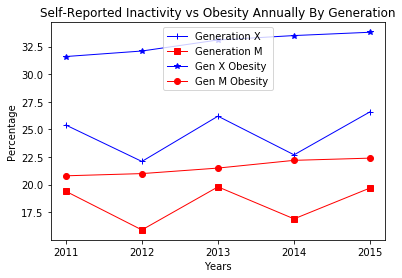

In [44]:
#ACTIVITY LINE GRAPHS -Dar
# Set x axis to numerical value for month
x_axis = "2011","2012","2013","2014","2015"



# Avearge GenX not exercising each year
activityGenX = [25.4, 22.1, 26.2, 22.7, 26.6]
# Avearge GenM not exercising each year
activityGenM = [19.4, 15.9, 19.8, 16.9, 19.7]
# Avearge GenX obese each year
obesityGenX = [31.6, 32.1, 33.1, 33.5, 33.8]
# Avearge GenM obese each year
obesityGenM = [20.8, 21, 21.5, 22.2, 22.4]

# Create a handle for each plot
genX, = plt.plot(x_axis, activityGenX, marker="+",color="blue", linewidth=1, label="Generation X")
genM, = plt.plot(x_axis, activityGenM, marker="s", color="Red", linewidth=1, label="Generation M")
genXo, = plt.plot(x_axis, obesityGenX, marker="*",color="blue", linewidth=1, label="Gen X Obesity")
genMo, = plt.plot(x_axis, obesityGenM, marker="o", color="Red", linewidth=1, label="Gen M Obesity")

# Set our legend to where the chart thinks is best
plt.legend(handles=[genX, genM, genXo, genMo], loc="best")

# Create labels for the X and Y axis
plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title('Self-Reported Inactivity vs Obesity Annually By Generation')


# Save and display the chart
# Save and display the chart
plt.savefig("Resources/NoActivityLineChart.png")
plt.show()

In [45]:
#Heavy Activity Dataframe - Dar

HeavyActivityGenM_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)")]
HeavyActivityGenX_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)")]

#Achieve Means by Years to plot using groupby
HeavyActivityYearsGenM_df =  HeavyActivityGenM_df.groupby("Year")["Data_Value"].mean()
HeavyActivityYearsGenX_df =  HeavyActivityGenX_df.groupby("Year")["Data_Value"].mean()

HeavyActivityYearsGenX_df.head()

Year
2011    29.197059
2013    29.335294
2015    29.384314
2017    28.387255
Name: Data_Value, dtype: float64

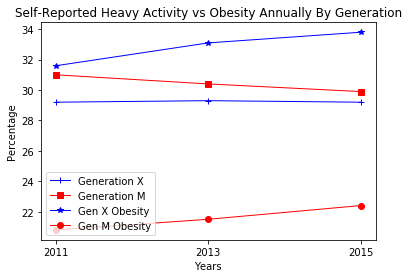

In [46]:
#ACTIVITY LINE GRAPHS- Heavy Activity -Dar
# Set x axis to numerical value for month
x_axis = "2011","2013","2015"



# Avearge GenX not exercising each year
activityGenX = [29.2, 29.3, 29.2]
# Avearge GenM not exercising each year
activityGenM = [31, 30.4, 29.9]
# Avearge GenX obese each year
obesityGenX = [31.6, 33.1, 33.8]
# Avearge GenM obese each year
obesityGenM = [20.8, 21.5, 22.4]

# Create a handle for each plot
genX, = plt.plot(x_axis, activityGenX, marker="+",color="blue", linewidth=1, label="Generation X")
genM, = plt.plot(x_axis, activityGenM, marker="s", color="Red", linewidth=1, label="Generation M")
genXo, = plt.plot(x_axis, obesityGenX, marker="*",color="blue", linewidth=1, label="Gen X Obesity")
genMo, = plt.plot(x_axis, obesityGenM, marker="o", color="Red", linewidth=1, label="Gen M Obesity")

# Set our legend to where the chart thinks is best
plt.legend(handles=[genX, genM, genXo, genMo], loc="best")

# Create labels for the X and Y axis
plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title('Self-Reported Heavy Activity vs Obesity Annually By Generation')


# Save and display the chart
# Save and display the chart
plt.savefig("Resources/HeavyActivityLineChart.png")
plt.show()

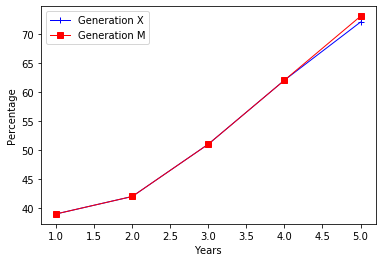

In [47]:
#NUTRITION LINE GRAPHS -Dar
# Set x axis to numerical value for month
x_axis = np.arange(1,6,1)
x_axis

# Avearge GenX not exercising each year
nutritionGenX = [39, 42, 51, 62, 72]
# Avearge GenM not exercising each year
nutritionGenM = [39, 42, 51, 62, 73]

# Create a handle for each plot
genX, = plt.plot(x_axis, nutritionGenX, marker="+",color="blue", linewidth=1, label="Generation X")
genM, = plt.plot(x_axis, nutritionGenM, marker="s", color="Red", linewidth=1, label="Generation M")

# Set our legend to where the chart thinks is best
plt.legend(handles=[genX, genM], loc="best")

# Create labels for the X and Y axis
plt.xlabel("Years")
plt.ylabel("Percentage")

# Save and display the chart

plt.show()

#NUTRITION LINE GRAPHS WILL NOT WORK AS THERE IS ONLY ONE YEAR (2017) REPRESENTED##

In [ ]:
#Hooray We Finished Project 1!